# Layout

+ Intro algebra
    + news
    + physics
+ doc2vec
    + press releases
+ score function
    + gensim
+ dimensions example, e.g. he-she

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import random
from numpy import linalg as LA
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics.pairwise

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths
import json

# Intro

intro stuff ...

# Getting our corpuses

Instead of downloading our corpora, we have download them ahead of time, a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `data/grimmerPressReleases`. So we will load them into a DataFrame, to do this first we need to define a function to convert directories of text files into DataFrames.

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = 'data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...


# Stemming is taking a really long time do to the size of the dataset, so it's been disabled for now

We also want to remove stop words and stem, but tokenizing requires two steps. Word2Vec wants to know the sentence structure as well as simply the words, so the tokenizing is slightly different this time.

In [4]:
#Define the same function as last week
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, stopwordLst = stop_words_nltk, stemmer = None) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, se..."
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, plan..."
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, u,..."
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, senator, edward,..."
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, impo..."
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Now we can look at a few things

In [7]:
senReleasesW2V.most_similar('president')

[('administration', 0.767875075340271),
 ('presidents', 0.7209091186523438),
 ('administrations', 0.643993079662323),
 ('cheney', 0.6200817823410034),
 ('george', 0.6187437772750854),
 ('sims', 0.5513560771942139),
 ('lamont', 0.5374098420143127),
 ('responds', 0.5324071049690247),
 ('sticklers', 0.5251588821411133),
 ('gop', 0.5244453549385071)]

Get the vector

In [8]:
senReleasesW2V['president'] + senReleasesW2V['boston']

array([ -4.93829370e-01,  -7.07372904e-01,  -7.33363271e-01,
         3.94004583e+00,  -2.77008629e+00,  -1.69073820e-01,
         2.28243232e-01,   1.34793282e+00,   1.11577427e+00,
        -1.09153509e+00,   1.28537512e+00,   7.74690688e-01,
         1.33202839e+00,  -1.52590871e+00,  -7.45350420e-01,
        -2.41141653e+00,  -3.65323210e+00,  -9.04407501e-01,
         1.54135108e-01,   8.86742532e-01,  -1.13891566e+00,
         1.54384804e+00,   3.91846672e-02,   1.03173697e+00,
         4.89052474e-01,  -3.13266814e-01,  -1.48977947e+00,
         9.62597787e-01,  -2.74774647e+00,  -4.73465681e-01,
        -2.70326924e+00,   3.12065506e+00,  -1.08340669e+00,
        -3.23738742e+00,  -1.12316012e+00,   1.83545208e+00,
        -5.99481463e-02,   2.07026553e+00,  -2.49476016e-01,
        -1.12838459e+00,   2.27729273e+00,   2.33177090e+00,
         1.48422122e-02,  -2.27779102e+00,  -1.65592825e+00,
         3.10185719e+00,   1.25134385e+00,   1.15311337e+00,
         1.94027257e+00,

Get all the vectors

In [9]:
senReleasesW2V.syn0

array([[ -7.66528904e-01,  -7.74559658e-03,  -7.08542287e-01, ...,
          8.69116336e-02,  -1.98794210e+00,   9.61682677e-01],
       [ -1.85294163e+00,  -2.23919034e+00,  -1.93059301e+00, ...,
         -2.59512335e-01,   9.57921565e-01,   2.25334144e+00],
       [ -2.20167294e-01,  -1.70658326e+00,   4.16867733e-01, ...,
          1.64416146e+00,  -3.49210858e+00,   1.96939027e+00],
       ..., 
       [ -6.08311370e-02,  -2.16851663e-03,   6.61102161e-02, ...,
         -2.20043454e-02,  -8.52952078e-02,   3.95070985e-02],
       [ -6.84504732e-02,   4.11770679e-02,   6.39711842e-02, ...,
          5.42508289e-02,   6.48306236e-02,   4.60745906e-03],
       [  4.77549806e-03,  -1.14088051e-01,   3.96514200e-02, ...,
         -6.81674331e-02,  -1.26493173e-02,  -1.43582118e-04]], dtype=float32)

Find what doesn't fit

In [10]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

In [11]:
def myDoesntmatch(w2v, words):
    mean = w2v[words[0]]
    for w in words[1:]:
        mean += w2v[w]
    mean = mean / len(words)
    worst = words[0]
    wv = 0
    for w in words:
        v = abs(np.dot(mean, w2v[w]))
        if v > wv:
            wv = v
            worst = w
    return worst
myDoesntmatch(senReleasesW2V, ['administration', 'administrations', 'presidents', 'president', 'washington'])

'administration'

Or save for use later

In [12]:
senReleasesW2V.save("data/senpressreleasesWORD2Vec")

We can also use the documensts themselves instead of the sentences to generate the model, this is called [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html).

In [13]:
gensim.models.doc2vec.LabeledSentence(words = [''], tags = [''])

LabeledSentence(words=[''], tags=[''])

In [14]:
taggedDocs = []
for index, row in senReleasesDF.iterrows():
    #taggedDocs.append(row)
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_sents'][0], tags = row['category']))
senReleasesDF['TaggedDocuments'] = taggedDocs

We can then train the model the same way as before

In [15]:
senReleasesW2V = gensim.models.doc2vec.Doc2Vec(senReleasesDF['TaggedDocuments'])
#senReleasesW2V.build_vocab([0])

In [16]:
senReleasesW2V.train(senReleasesDF['TaggedDocuments'])

6532105

In [17]:
import sklearn.manifold
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 50).fit(senReleasesW2V.syn0)
reducedPCA_data = pca.transform(senReleasesW2V.syn0)

tsne = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)


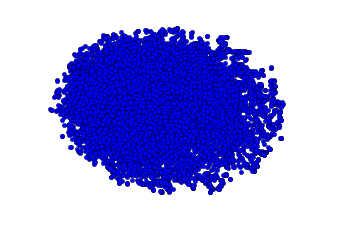

In [18]:

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.xticks(())
plt.yticks(())
#plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

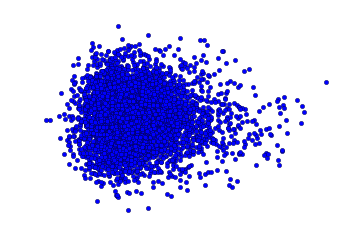

In [19]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1])
plt.xticks(())
plt.yticks(())
#plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

# Doc2Vec

We can instead of looking at just how the words embed in the space, look at how the different spaces relate to each other. First lets load our data, some abstracts of physics papers from the 1950s.

In [20]:
apsDF = pandas.read_csv('data/APSabstracts1950s.csv', index_col = 0)
apsDF[::100]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
100,1955,10.1103/PhysRev.100.1115,Hutson has recently observed a non-Maxwellian ...
200,1955,10.1103/PhysRev.100.1643,The creation of vacancies in sodium chloride b...
300,1955,10.1103/PhysRev.100.641,Various theoretical explanations for the absen...
400,1956,10.1103/PhysRev.101.1198,The importance of a pion-pion attraction for c...
500,1956,10.1103/PhysRev.101.1713,Results are obtained for the photomagnetoelect...
600,1956,10.1103/PhysRev.101.594,"Bethe's ""average excitation potentials"" for st..."
700,1956,10.1103/PhysRev.102.1104,The existence of an excited state in He4 may b...
800,1956,10.1103/PhysRev.102.1684,A general relation is shown to exist between t...
900,1956,10.1103/PhysRev.102.674,The effect on cobalt ferrite of heat treatment...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [21]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk))

In [29]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical']

In [30]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec

In [31]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get the vectors for the tags/documents

In [32]:
apsD2V.docvecs[1952]

array([  7.69822970e-02,  -3.77989747e-02,  -1.12552131e-02,
         4.40138988e-02,  -4.93884385e-02,  -1.36662610e-02,
        -4.28192317e-02,   1.63782284e-01,   2.33574566e-02,
        -8.60052183e-02,  -6.37853369e-02,  -9.31947157e-02,
         8.73527527e-02,   4.33305744e-03,   6.25017956e-02,
        -2.04580843e-01,   2.63630785e-02,   1.51601896e-01,
        -3.63250151e-02,  -1.76335603e-01,  -7.32272863e-02,
        -1.86453387e-01,   1.54377982e-01,  -7.97559917e-02,
         9.65394378e-02,   8.07126462e-02,  -7.16658160e-02,
        -2.24641506e-02,  -2.07913015e-03,  -5.89419156e-02,
        -4.14445028e-02,   2.85027344e-02,  -9.93491113e-02,
        -1.56907842e-01,  -8.80901422e-03,   2.41651442e-02,
        -1.20740823e-01,  -2.49806475e-02,   3.54174264e-02,
         1.70661435e-02,  -4.72949222e-02,  -1.30846158e-01,
        -3.57935093e-02,   1.83459595e-02,   1.96812414e-02,
         6.84498549e-02,  -6.78420141e-02,   4.92580384e-02,
         6.28260598e-02,

As well as for words

In [33]:
apsD2V['electron']

array([ 0.31203398, -0.01663999, -0.09782565, -0.05897403,  0.00247387,
        0.1319741 , -0.04128956,  0.16406798,  0.08441073, -0.00170421,
        0.08883807, -0.0782712 ,  0.07888393,  0.11218871, -0.24193829,
        0.31015912, -0.11336057, -0.08433217, -0.03340527, -0.13139327,
       -0.07542676,  0.22238664,  0.03001444,  0.01468385,  0.27224964,
       -0.11968805,  0.01484647,  0.12412385,  0.1682519 , -0.09627728,
        0.01970929,  0.10024589, -0.08803757,  0.08429518, -0.19487259,
       -0.15862422, -0.02999708, -0.1322189 , -0.0188905 , -0.02149843,
       -0.02258727, -0.08505835,  0.07694624, -0.01549684, -0.02778758,
       -0.12342361, -0.1149113 ,  0.01915803, -0.13891256,  0.25809854,
       -0.11656318,  0.04216111, -0.0341577 , -0.16517781, -0.07297976,
        0.13730444,  0.1097477 ,  0.08991272,  0.02847754, -0.01055015,
        0.01202344, -0.08335961,  0.25861841, -0.13352968, -0.07748759,
        0.05356456,  0.15337884, -0.00523226, -0.06423835, -0.18

In [34]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'], apsD2V['positron'])

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.34354025]], dtype=float32)

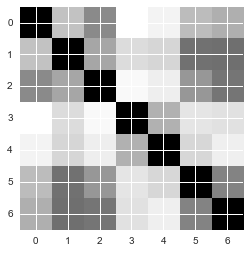

In [43]:
heatmap = []
for k in keywords:
    heatrow = []
    for j in keywords:
        #reshape(-1, 1) to make sklearn stop complaining
        heatrow.append(sklearn.metrics.pairwise.cosine_similarity(apsD2V.docvecs[k].reshape(1, -1), apsD2V.docvecs[j].reshape(1, -1))[0][0])
    heatmap.append(heatrow.copy())
heatmap = np.array(heatmap)
plt.imshow(heatmap, interpolation='nearest')
#heatmap

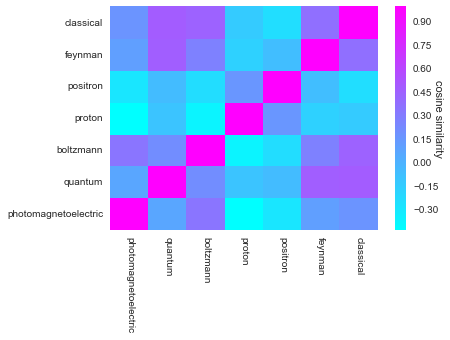

In [49]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmap, cmap='cool')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
ax.set_xticks(np.arange(heatmap.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(heatmap.shape[0]) + 0.5, minor=False)

ax.set_xticklabels(keywords, minor=False, rotation=270)
ax.set_yticklabels(keywords, minor=False)


Here, let's change some parameters. Let's use skipgrams instead of CBOW (continous bag of words), have a 200-dimensional vector space, only keep words that appear more than 2 times, and iterate the training algorithm over the corpus 10 times. For more information about parametrizing word2vec models, please see [here](https://radimrehurek.com/gensim/models/word2vec.html) and [here](https://code.google.com/archive/p/word2vec/).

Let's save the model.

In [56]:
apsD2V.save('data/apsW2V')

We can then also load it.

In [57]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/random230K.model')#, binary=True)

Now let's do some vector algebra.

In [58]:
apsD2V.most_similar(positive = ['boltzmann', 'schroedinger'], negative = ['statistical'], topn = 5)

[('schrdinger', 0.747092068195343),
 ('continuity', 0.690601110458374),
 ('integral', 0.6401292085647583),
 ('liouville', 0.6177884340286255),
 ('secular', 0.6035773158073425)]

# News from The New York Times 

In [59]:
paragraphs = []
f = open('data/nytimes_full.txt', 'r')
for row in f:
    if row != '\n' and  row != "';\n":
        paragraphs.append(row)
f.close()

In [ ]:
indices = random.sample(range(len(paragraphs)), 5000)

In [ ]:
sample = [paragraphs[i] for i in sorted(indices)]

# The Score Function

In [140]:
path = 'data/resumeAll.short.model'
resume_model  = gensim.models.word2vec.Word2Vec.load(path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/resumeAll.short.model'

We can take a look at the vacabularies of this model.

In [61]:
resume_model.index2word

NameError: name 'resume_model' is not defined

Let's load some job ads.

# Projection

We can project word vectors to some dimension. To demonstrate this functionality, let's first load a model trained with New York Times news articles. 

In [122]:
nytimes_model = gensim.models.word2vec.Word2Vec.load_word2vec_format('data/nytimes_cbow.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'data/nytimes_cbow.txt'

In [132]:
nytimes_model = gensim.models.word2vec.Word2Vec.load_word2vec_format('data/nytimes_cbow.reduced.txt')

Define some convenient functions for getting dimensions. 

In [133]:
def normalize(vector):
    normalized_vector = vector / LA.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [134]:
#nytimes_model['already']

Let's calculate three dimensions: gender, race, and class.

In [135]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [136]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [137]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(cosine_similarity(nytimes_model[word], Gender)[0][0])
        r.append(cosine_similarity(nytimes_model[word], Race)[0][0])
        c.append(cosine_similarity(nytimes_model[word], Class)[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [138]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

Define some useful functions for plotting.

In [139]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

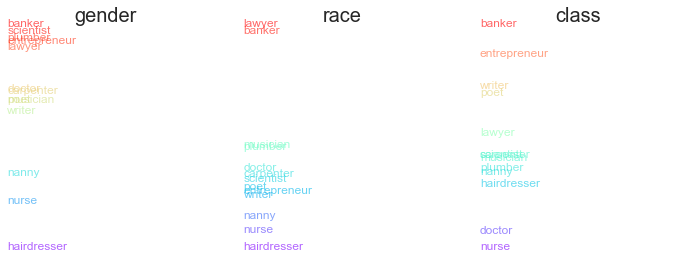

In [129]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods.

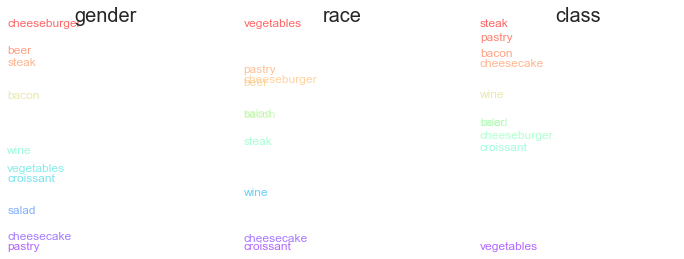

In [130]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports

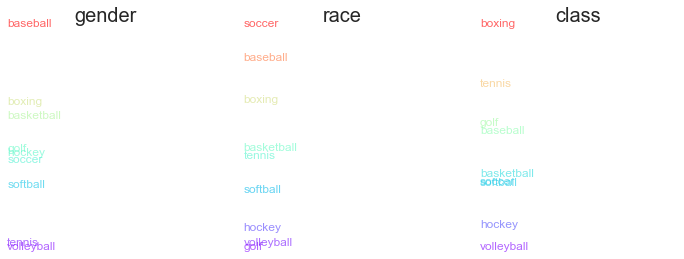

In [131]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()